 # Homework 5
 ## Group 10

## Assignment 1 - Reviews

We review the homeworks for groups 15 and 32.

## Assignment 2 - CIFAR-10 Classification

In [61]:
# the necessary imports

import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import datetime as datetime
import tqdm

### 2.1 Prepare the Dataset

In [62]:
def preprocess(dataset):

    # convert data from uint8 to float32
    dataset = dataset.map(lambda img, target: (tf.cast(img, tf.float32), target))

    # flatten the images into vectors - we don't do this step for CNN, CNN layers expect standard image format input
    # dataset = dataset.map(lambda img, target: (tf.reshape(img, (-1,)), target))

    # input normalization, just bringing image values from range [0, 255] to [-1, 1]
    dataset = dataset.map(lambda img, target: ((img / 128.) - 1., target))

    # create one-hot targets with depth 10 since cifar 10 has 10 classes
    dataset = dataset.map(lambda img, target: (img, tf.one_hot(target, depth=10)))

    # cache
    dataset = dataset.cache()

    # shuffle, batch, prefetch
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(32)
    dataset = dataset.prefetch(tf.data.AUTOTUNE) 

    # return preprocessed dataset
    return dataset

ds_info: 
 tfds.core.DatasetInfo(
    name='cifar10',
    full_name='cifar10/3.0.2',
    description="""
    The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_path='C:\\Users\\powel\\tensorflow_datasets\\cifar10\\3.0.2',
    file_format=tfrecord,
    download_size=162.17 MiB,
    dataset_size=132.40 MiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=50000, num_shards=1>,
    },
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex K

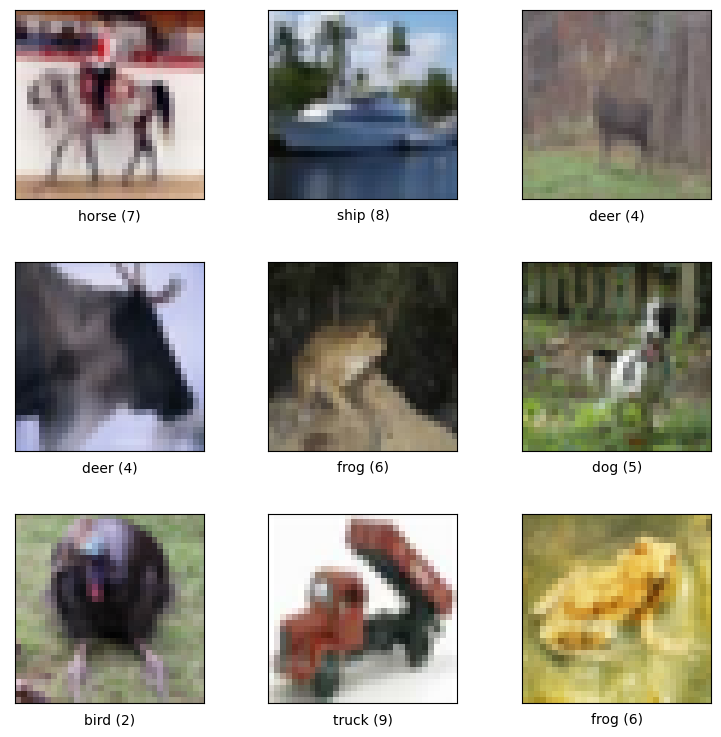

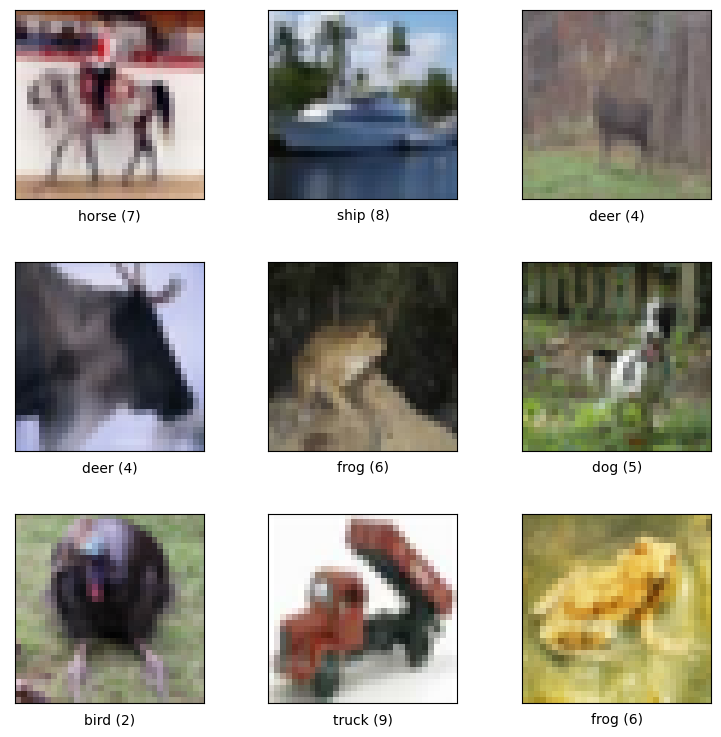

In [63]:
(train_ds, test_ds), ds_info = tfds.load ('cifar10', split =['train', 'test'], as_supervised = True, with_info = True)

print("ds_info: \n", ds_info)

# visualize a sample of the dataset
tfds.show_examples(train_ds, ds_info)


In [64]:
train_dataset = preprocess(train_ds)
test_dataset = preprocess(test_ds)

### 2.2 Create a CNN Model

In [65]:
# straight from the lecture
class BasicConv(tf.keras.Model):
    def __init__(self):
        super(BasicConv, self).__init__()

        # input 32x32x3 with 3 as the color channels
        self.convlayer1 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu') # after this: 32x32x24
        self.convlayer2 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu') # 32x32x24
        self.convlayer3 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu') # 32x32x24

        self.pooling = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2) # 16x16x24

        #self.normlayer = tf.keras.layers.Normalization(axis=-1,mean=None,invert=False)

        self.convlayer4 = tf.keras.layers.Conv2D(filters=72, kernel_size=3, padding='same', activation='relu') # 16x16x48
        self.convlayer5 = tf.keras.layers.Conv2D(filters=72, kernel_size=3, padding='same', activation='relu') # 16x16x48
        self.convlayer6 = tf.keras.layers.Conv2D(filters=72, kernel_size=3, padding='same', activation='relu') # 32x32x24

        self.global_pool = tf.keras.layers.GlobalAvgPool2D() # 1x1x48

        self.out = tf.keras.layers.Dense(10, activation='softmax')

        self.loss_function = tf.keras.losses.CategoricalCrossentropy()
        self.optimizer = tf.keras.optimizers.Adam()

        self.metrics_list = [
                    tf.keras.metrics.Mean(name="loss"),
                    tf.keras.metrics.BinaryAccuracy(name="acc"), # only for subtask 0, not for subtask 1
                    ]

    @tf.function
    def call(self, x):
        x = self.convlayer1(x)
        x = self.convlayer2(x)
        x = self.convlayer3(x)
        x = self.pooling(x)
        x = self.convlayer4(x)
        x = self.convlayer5(x)
        x = self.convlayer6(x)
        x = self.global_pool(x)
        x = self.out(x)
        return x


    @property
    def metrics(self):
        return self.metrics_list

    def reset_metrics(self):
        for metric in self.metrics:
            metric.reset_states()

    @tf.function
    def train_step(self, input):
        img, label = input

        with tf.GradientTape() as tape:
            prediction = self(img, training=True)
            loss = self.loss_function(label, prediction)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        # update loss metric
        self.metrics[0].update_state(loss)

        # for all metrics except loss, update states (accuracy etc.)
        for metric in self.metrics[1:]:
            metric.update_state(label, prediction) # + tf.reduce_sum(self.losses)

        # Return a dictionary mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

    @tf.function
    def test_step(self, input):

        img, label = input

        prediction = self(img, training=False)
        loss = self.loss_function(label, prediction) # + tf.reduce_sum(self.losses)

        # update loss metric
        self.metrics[0].update_state(loss)

        # for accuracy metrics:
        for metric in self.metrics[1:]:
            metric.update_state(label, prediction)

        # Return a dictionary mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}


In [66]:
# Initiate the logs and metrics
config_name= "config_name"
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

train_log_path = f"logs/{config_name}/{current_time}/train"
val_log_path = f"logs/{config_name}/{current_time}/val"

# log writer for training metrics
train_summary_writer = tf.summary.create_file_writer(train_log_path)

# log writer for validation metrics
val_summary_writer = tf.summary.create_file_writer(val_log_path)

# Initiate epochs and learning rate as global variables
epochs = 15
learning_rate = 0.05

# Define arrays for saving values for later visualization
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

### 2.3 Training

In [67]:
# define the training loop

def training():

    network = BasicConv()

    # Train the model
    for epoch in range(epochs):
        print(f"Epoch: {epoch}, optimizer: {network.optimizer}")

        for data in tqdm.tqdm(train_dataset, position=0, leave=True):
            metrics = network.train_step(data)

            with train_summary_writer.as_default():
                for metric in network.metrics:
                    tf.summary.scalar(f"{metric.name}", metric.result(), step=epoch)

        # print the end acc and loss
        print([f"train_{key}: {value.numpy()}" for (key, value) in metrics.items()])

        # make a list of losses and accuracies
        for (key, value) in metrics.items():
            if key == "loss":
                train_losses.append(value.numpy())
            elif key == "acc":
                train_accuracies.append(value.numpy())

        # reset metrics for next round
        network.reset_metrics()

        # Testing
        for data in test_dataset:
            metrics = network.test_step(data)

            # log the accs and losses
            with val_summary_writer.as_default():
                for metric in network.metrics:
                    tf.summary.scalar(f"{metric.name}", metric.result(), step = epoch)

        # print the end acc and loss
        print([f"val_{key}: {value.numpy()}" for (key, value) in metrics.items()])

        # make a list of losses and accuracies
        for (key, value) in metrics.items():
            if key == "loss":
                val_losses.append(value.numpy())
            elif key == "acc":
                val_accuracies.append(value.numpy())

        # reset all metrics
        network.reset_metrics()

In [68]:
# prepare the tensorboard ahead of training

%load_ext tensorboard
%tensorboard --logdir logs/fit

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Launching TensorBoard...

In [69]:
training()

Epoch: 0, optimizer: <keras.optimizers.optimizer_v2.adam.Adam object at 0x000001DD21A0E040>


100%|██████████| 1563/1563 [04:18<00:00,  6.05it/s]


['train_loss: 1.6291849613189697', 'train_acc: 0.9076399803161621']
['val_loss: 1.3539339303970337', 'val_acc: 0.9183099865913391']
Epoch: 1, optimizer: <keras.optimizers.optimizer_v2.adam.Adam object at 0x000001DD21A0E040>


100%|██████████| 1563/1563 [06:47<00:00,  3.84it/s]


['train_loss: 1.1481354236602783', 'train_acc: 0.9281200170516968']
['val_loss: 1.077683687210083', 'val_acc: 0.9320300221443176']
Epoch: 2, optimizer: <keras.optimizers.optimizer_v2.adam.Adam object at 0x000001DD21A0E040>


100%|██████████| 1563/1563 [05:03<00:00,  5.15it/s]


['train_loss: 0.938953697681427', 'train_acc: 0.9398599863052368']
['val_loss: 0.8922333717346191', 'val_acc: 0.9431399703025818']
Epoch: 3, optimizer: <keras.optimizers.optimizer_v2.adam.Adam object at 0x000001DD21A0E040>


100%|██████████| 1563/1563 [05:33<00:00,  4.68it/s]


['train_loss: 0.8167586922645569', 'train_acc: 0.947405993938446']
['val_loss: 0.8815212249755859', 'val_acc: 0.9433599710464478']
Epoch: 4, optimizer: <keras.optimizers.optimizer_v2.adam.Adam object at 0x000001DD21A0E040>


100%|██████████| 1563/1563 [04:04<00:00,  6.39it/s]


['train_loss: 0.7282198071479797', 'train_acc: 0.9528239965438843']
['val_loss: 0.7821171879768372', 'val_acc: 0.9506000280380249']
Epoch: 5, optimizer: <keras.optimizers.optimizer_v2.adam.Adam object at 0x000001DD21A0E040>


100%|██████████| 1563/1563 [04:07<00:00,  6.32it/s]


['train_loss: 0.6571874618530273', 'train_acc: 0.957207977771759']
['val_loss: 0.7009038925170898', 'val_acc: 0.9551399946212769']
Epoch: 6, optimizer: <keras.optimizers.optimizer_v2.adam.Adam object at 0x000001DD21A0E040>


100%|██████████| 1563/1563 [05:30<00:00,  4.72it/s]


['train_loss: 0.5968496203422546', 'train_acc: 0.9608920216560364']
['val_loss: 0.6742672324180603', 'val_acc: 0.957260012626648']
Epoch: 7, optimizer: <keras.optimizers.optimizer_v2.adam.Adam object at 0x000001DD21A0E040>


100%|██████████| 1563/1563 [05:11<00:00,  5.02it/s]


['train_loss: 0.5479970574378967', 'train_acc: 0.9641119837760925']
['val_loss: 0.6987177133560181', 'val_acc: 0.955590009689331']
Epoch: 8, optimizer: <keras.optimizers.optimizer_v2.adam.Adam object at 0x000001DD21A0E040>


100%|██████████| 1563/1563 [05:04<00:00,  5.14it/s]


['train_loss: 0.5057065486907959', 'train_acc: 0.9664400219917297']
['val_loss: 0.6648362874984741', 'val_acc: 0.9591900110244751']
Epoch: 9, optimizer: <keras.optimizers.optimizer_v2.adam.Adam object at 0x000001DD21A0E040>


100%|██████████| 1563/1563 [05:02<00:00,  5.17it/s]


['train_loss: 0.4638223946094513', 'train_acc: 0.9690539836883545']
['val_loss: 0.7190706729888916', 'val_acc: 0.9561799764633179']
Epoch: 10, optimizer: <keras.optimizers.optimizer_v2.adam.Adam object at 0x000001DD21A0E040>


100%|██████████| 1563/1563 [04:51<00:00,  5.36it/s]


['train_loss: 0.4263285994529724', 'train_acc: 0.9715560078620911']
['val_loss: 0.6961066722869873', 'val_acc: 0.9581300020217896']
Epoch: 11, optimizer: <keras.optimizers.optimizer_v2.adam.Adam object at 0x000001DD21A0E040>


100%|██████████| 1563/1563 [04:51<00:00,  5.36it/s]


['train_loss: 0.3920333683490753', 'train_acc: 0.9738199710845947']
['val_loss: 0.7035625576972961', 'val_acc: 0.9589499831199646']
Epoch: 12, optimizer: <keras.optimizers.optimizer_v2.adam.Adam object at 0x000001DD21A0E040>


100%|██████████| 1563/1563 [04:58<00:00,  5.24it/s]


['train_loss: 0.3610776960849762', 'train_acc: 0.9756799936294556']
['val_loss: 0.697395920753479', 'val_acc: 0.9596199989318848']
Epoch: 13, optimizer: <keras.optimizers.optimizer_v2.adam.Adam object at 0x000001DD21A0E040>


100%|██████████| 1563/1563 [04:58<00:00,  5.23it/s]


['train_loss: 0.327910453081131', 'train_acc: 0.977840006351471']
['val_loss: 0.7083757519721985', 'val_acc: 0.9602800011634827']
Epoch: 14, optimizer: <keras.optimizers.optimizer_v2.adam.Adam object at 0x000001DD21A0E040>


100%|██████████| 1563/1563 [04:55<00:00,  5.29it/s]


['train_loss: 0.30018383264541626', 'train_acc: 0.979781985282898']
['val_loss: 0.7703375220298767', 'val_acc: 0.9581300020217896']


### 2.4 - Visualization

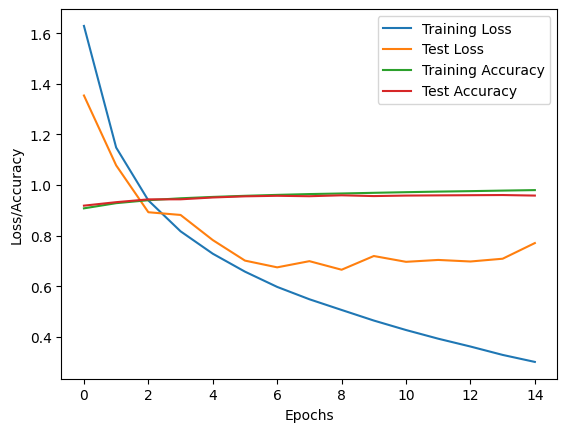

In [70]:
# visualize the results

fig = plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(val_losses)
line3, = plt.plot(train_accuracies)
line4, = plt.plot(val_accuracies)
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend((line1,line2,line3,line4),("Training Loss","Test Loss","Training Accuracy","Test Accuracy"))
fig.savefig("CNN Performance CIFAR-10")
plt.show()

### Assignment 3 - Playing with Parameters

We tested several configurations of our network to see what worked best. Increasinbg the number of filters per layer (upping each existing amount by 24 or less, nothing extreme) and adding additional layers (one before and after the middle pooling layer, nothing extreme) both increased performance appreciably. A higher learning rate (0.05 versus 0.01) also resulted in better performance. Lowering the batch size to 32 from our original 64 also helped. We tried swapping out the middle pooling layer for a normalization layer, but this resulted in slower training and worse performance, so we did not pursue this track further at this time.

Our best performing model had the settings as shown above, which is a combination of the elements we discovered boosted performance (i.e. more layers, more filters, higher learning rate, and a batch size of 32). This architecture and its results were posted to the shared class Doc (3.1). The plateau in validation accuracy may have come from overfitting as a result of the increased layers, as with CIFAR-10 it is very possible for a network to learn features in a given sample that are not helpful when generalizing to new data.